# Tower detection CNN deep learning model

*by: Toma Hasei

In [37]:
from fastai.vision import *
from fastai.widgets import *
from starlette.applications import Starlette
from starlette.responses import JSONResponse
import uvicorn

## Get a list of tower image URLs 

### Search and scroll

[Eiffel Tower](https://www.google.com/search?q=eiffel+tower+-deck+-model+-skytree+-tokyo&rlz=1C1CHBF_enUS832US833&tbm=isch&source=lnt&tbs=itp:photo&sa=X&ved=0ahUKEwiyo9PJxa3jAhVDaM0KHQy9AKkQpwUIIQ&biw=1242&bih=553&dpr=1.1)

[Tokyo Tower](https://www.google.com/search?q=tokyo+tower+-skytree+-deck+-eiffel+-model&hl=en&tbm=isch&source=lnt&tbs=itp:photo&sa=X&ved=0ahUKEwjRp82Qxa3jAhXBB50JHRtjBKAQpwUIIQ&biw=1242&bih=553&dpr=1.1#imgrc=rK2xpomUgAwVkM)

### Download into file

Javascript code to get image urls from Google Images
```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## Download images to directory

In [3]:
folder = 'tokyo'
file = 'tokyo.csv'

In [4]:
path = Path('data/towers')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [5]:
# downloading tokyo tower images
download_images(path/file, dest, max_pics=100) 

In [6]:
folder = 'eiffel'
file = 'eiffel.csv'
path = Path('data/towers')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
# downloading eiffel tower images
download_images(path/file, dest, max_pics=100) 

In [8]:
path.ls()

[PosixPath('data/towers/eiffel'),
 PosixPath('data/towers/export.pkl'),
 PosixPath('data/towers/.ipynb_checkpoints'),
 PosixPath('data/towers/models'),
 PosixPath('data/towers/tokyo'),
 PosixPath('data/towers/cleaned.csv'),
 PosixPath('data/towers/tokyo.csv'),
 PosixPath('data/towers/eiffel.csv')]

In [9]:
classes = ['tokyo','eiffel']

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [11]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [12]:
data.classes

['eiffel', 'tokyo']

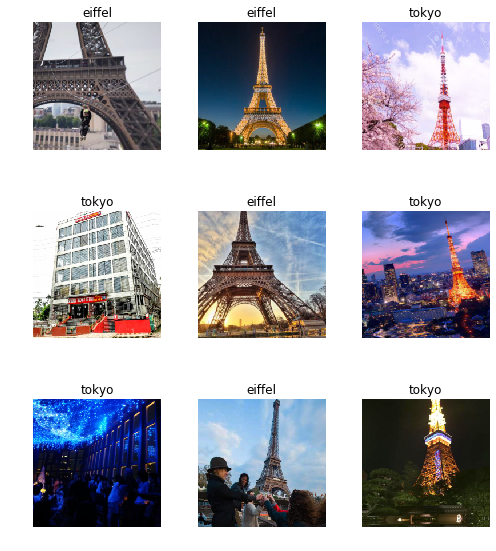

In [13]:
data.show_batch(rows=3, figsize=(7,8))

In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['eiffel', 'tokyo'], 2, 146, 36)

## Train model

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.893929,0.526668,0.250000,00:05
1,0.731081,0.241578,0.111111,00:01
2,0.534050,0.154451,0.055556,00:01
3,0.428568,0.124690,0.055556,00:02


In [17]:
learn.save('stage-1')

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


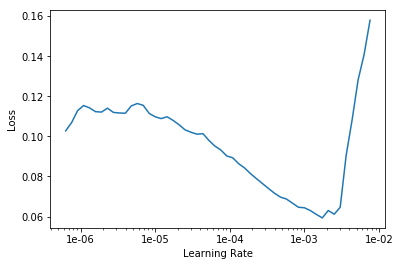

In [20]:
# Learning rate curve
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.187871,0.518245,0.166667,00:02
1,0.135634,0.270202,0.111111,00:02


In [22]:
learn.save('stage-2')

## Interpretation

In [23]:
learn.load('stage-2');

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

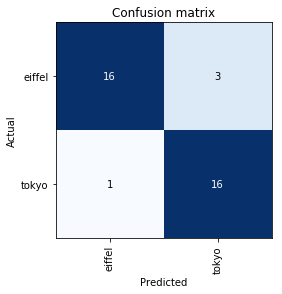

In [25]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

We can prune our top losses, removing photos that don't belong.

In [26]:
# selecting all tower images within the path
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [27]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [28]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [29]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [30]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting model in production

Export the content of our `Learner` object for production:

In [31]:
learn.export()

In [32]:
defaults.device = torch.device('cpu')

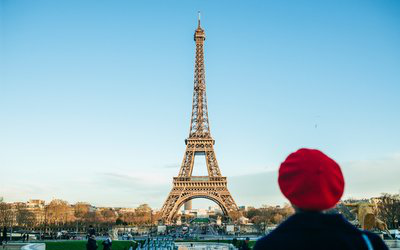

In [33]:
img = open_image(path/'eiffel'/'00000021.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [34]:
learn = load_learner(path)

In [35]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category eiffel

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs